In [1]:
import torch
import pandas as pd
from torch.optim import AdamW
from transformers import get_scheduler
import torch.nn as nn
from src.load_dataloader import initial_dataloader
from src.evaluation import evaluate
from src.evaluation import evaluate_process
from src.load_config import load_config
from src.evaluation import show_sentence
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

max_length = 64

In [2]:
model, tokenizer, device = load_config(max_length)


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
# import data
df = pd.read_csv('data_preprocess/datasets_combine.csv')
train_df, val_df,test_df, train_loader, val_loader, test_loader = initial_dataloader(df, tokenizer, max_length)

In [4]:
train_loader.dataset[0]

c:\Users\Ene\Desktop\CS505_github\Natural-Language_Project\src\load_dataloader.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(item['input_ids'], dtype=torch.long).squeeze(0),
c:\Users\Ene\Desktop\CS505_github\Natural-Language_Project\src\load_dataloader.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(item['attention_mask'], dtype=torch.long).squeeze(0),
c:\Users\Ene\Desktop\CS505_github\Natural-Language_Project\src\load_dataloader.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourc

{'input_ids': tensor([32099,   140,   128, 32099, 32099,    11,  1040,     1,     0,     0,
             0,     0, 32099, 32099, 32099,     0, 32099,     0, 32099, 32099,
             0, 32099, 32099, 32099,     0, 32099, 32099,     0, 32099, 32099,
         32099, 32099, 32099,     0, 32099,     0,     0,     0, 32099, 32099,
         32099, 32099,     0,     0, 32099, 32099,     0, 32099,     0,     0,
         32099,     0, 32099,     0,     0,     0,     0,     0,     0,     0,
             0,     0, 32099,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor([6434, -100, -100,   16,  157, -100, -100, -100, -100, -100, -100, -100,
            0,    0,    0, -100,    0, -100,    0,    0, -100,    0,    0,    0,
         -100,    0,    0, -100,    0,    0,    0,    0,    0, 

In [5]:
def train_baseline():
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=5e-5)
    num_epochs = 100
    num_training_steps = num_epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )

    for epoch in range(num_epochs):
        model.train()
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        accuracy = evaluate(model, val_loader, device)
        print(f"Epoch {epoch+1}: Accuracy = {accuracy:.2f}")
        
    # save 
    torch.save(model, 'baseline_model.pth')
    
# train_baseline()

In [6]:
baseline_model = torch.load('baseline_model.pth')
baseline_model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [7]:
# show sentence
for i in range(10):
    show_sentence(i, test_df, tokenizer, baseline_model, device, max_length)

Original Sentence: Authorities continue to search, seek leads
Target Sentence style: KING RICHARD II:Fiend, thou torment'st me ere I come to hell!HENRY BOLINGBROKE:Urge it no more, my Lord Northumberland
Generated Sentence: command
Original Sentence: Members prices are £70 for Band 1, with the cheapest member ticket £50
Target Sentence style: ANTIGONUS:I swear to do this, though a present deathHad been more merciful
Generated Sentence: 
Original Sentence: BAPTISTA:Now, in good sadness, son Petruchio,I think thou hast the veriest shrew of all
Target Sentence style: Mr Cameron said most of the guests were long standing acquaintances
Generated Sentence: translate to perfection
Original Sentence: Russia says it's investigating attack near embassy in Damascus
Target Sentence style: GREEN:Alas, poor duke! the task he undertakesIs numbering sands and drinking oceans dry:Where one on his side fights, thousands will fly
Generated Sentence: government shutdown
Original Sentence: So with me:My bi

In [8]:
predictions, labels = evaluate_process(test_df, baseline_model,tokenizer, device, max_length)

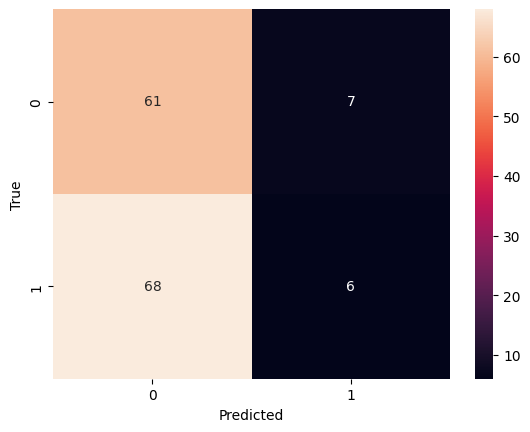

In [9]:
cm = confusion_matrix(labels, predictions)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

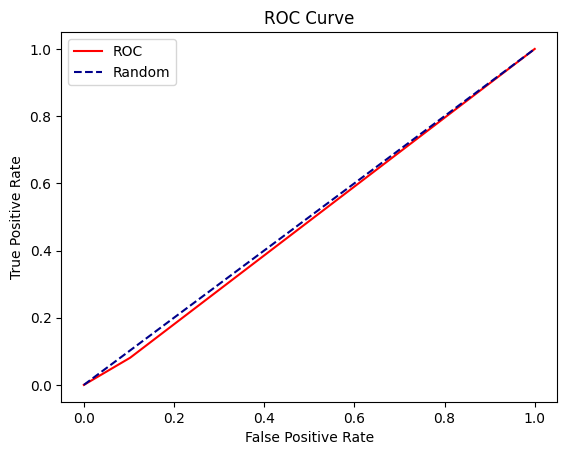

In [10]:
# plot ROC curve from confusion matrix
predict = predictions
True_label = labels
fpr, tpr, thresholds = roc_curve(True_label, predict)
auc = roc_auc_score(True_label, predict)
plt.plot(fpr, tpr, color='red', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()